## IMPORTS

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

## LOADING THE DATA

In [113]:
def load_and_normalize_json(filepath):
    """
    Loads JSON data from a file, normalizes the nested structure, and returns a DataFrame.

    Parameters:
    filepath (str): The path to the JSON file.

    Returns:
    pd.DataFrame: A DataFrame with normalized JSON data.
    """
    with open(filepath, 'r') as file:
        data = json.load(file)

    normalized_data = []

    for row in data:
        for item in row:
            if item:
                normalized_data.append(item)
                
    df = pd.DataFrame(normalized_data)

    return df

In [114]:
accounts_data_train = load_and_normalize_json('data/train/accounts_data_train.json')
enquiry_data_train = load_and_normalize_json('data/train/enquiry_data_train.json')
train_flag = pd.read_csv('data/train/train_flag.csv')

accounts_data_test = load_and_normalize_json('data/test/accounts_data_test.json')
enquiry_data_test = load_and_normalize_json('data/test/enquiry_data_test.json')
test_flag = pd.read_csv('data/test/test_flag.csv')

## EDA

### DATAFRAMES

In [115]:
accounts_data_train.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915


In [116]:
accounts_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245310 entries, 0 to 1245309
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   credit_type          1245310 non-null  object 
 1   loan_amount          1245307 non-null  float64
 2   amount_overdue       1245310 non-null  float64
 3   open_date            1245310 non-null  object 
 4   closed_date          782275 non-null   object 
 5   payment_hist_string  1245310 non-null  object 
 6   uid                  1245310 non-null  object 
dtypes: float64(2), object(5)
memory usage: 66.5+ MB


In [117]:
enquiry_data_train.head()

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Interbank credit,168839,2020-11-08,AAA08065248
1,Mobile operator loan,268392,2020-09-20,AAA08065248
2,Mobile operator loan,36082,2020-06-19,AAA08065248
3,Interbank credit,180467,2019-10-22,AAA08065248
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248


In [118]:
enquiry_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909926 entries, 0 to 1909925
Data columns (total 4 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   enquiry_type  object
 1   enquiry_amt   int64 
 2   enquiry_date  object
 3   uid           object
dtypes: int64(1), object(3)
memory usage: 58.3+ MB


In [119]:
train_flag.head()

,uid,NAME_CONTRACT_TYPE,TARGET
0,XDA69787158,Cash loans,0
1,BSE47789733,Cash loans,0
2,NTJ92213825,Cash loans,0
3,TCQ47571695,Cash loans,0
4,WJZ68772744,Cash loans,0


In [120]:
train_flag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261383 entries, 0 to 261382
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   uid                 261383 non-null  object
 1   NAME_CONTRACT_TYPE  261383 non-null  object
 2   TARGET              261383 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.0+ MB


In [121]:
print(accounts_data_train['uid'].nunique())
print(enquiry_data_train['uid'].nunique())
print(train_flag['uid'].nunique())

223918
261383
261383


In [122]:
print(accounts_data_test['uid'].nunique())
print(enquiry_data_test['uid'].nunique())
print(test_flag['uid'].nunique())

39572
46127
46127


### FEATURE ENGINEERING

In [123]:
def create_features(df):

    df['enquiry_date'] = pd.to_datetime(df['enquiry_date'])
    grouped = df.groupby('uid')

    count_enquiries = grouped.size().rename('count_enquiries')
    
    total_amt = grouped['enquiry_amt'].sum().rename('total_enquiry_amt')
    mean_amt = grouped['enquiry_amt'].mean().rename('mean_enquiry_amt')
    max_amt = grouped['enquiry_amt'].max().rename('max_enquiry_amt')
    
    last_enquiry = grouped['enquiry_date'].max().rename('last_enquiry_date')
    first_enquiry = grouped['enquiry_date'].min().rename('first_enquiry_date')
    time_since_last = (pd.Timestamp('now') - last_enquiry).dt.days.rename('time_since_last_enquiry')
    time_since_first = (pd.Timestamp('now') - first_enquiry).dt.days.rename('time_since_first_enquiry')
    avg_time_between = (time_since_first / (count_enquiries - 1)).replace([float('inf'), -float('inf')], 0).rename('avg_time_between_enquiries')
    
    features = pd.concat([count_enquiries, total_amt, mean_amt, max_amt, time_since_last, time_since_first, avg_time_between], axis=1)

    return features.reset_index()

In [124]:
enquiry_train_features = create_features(enquiry_data_train)
enquiry_test_features = create_features(enquiry_data_test)

In [125]:
enquiry_train_features.head()

,uid,count_enquiries,total_enquiry_amt,mean_enquiry_amt,max_enquiry_amt,time_since_last_enquiry,time_since_first_enquiry,avg_time_between_enquiries
0,AAA08065248,11,2064658,187696.181818,364751,1261,1931,193.100000
1,AAA09044550,26,2659000,102269.230769,197000,1262,2431,97.240000
2,AAA10545297,14,1317000,94071.428571,192000,1323,2169,166.846154
3,AAA14112888,15,1465000,97666.666667,185000,1439,2618,187.000000
4,AAA20326915,1,66000,66000.000000,66000,1399,1399,0.000000


In [126]:
enquiry_train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261383 entries, 0 to 261382
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   uid                         261383 non-null  object 
 1   count_enquiries             261383 non-null  int64  
 2   total_enquiry_amt           261383 non-null  int64  
 3   mean_enquiry_amt            261383 non-null  float64
 4   max_enquiry_amt             261383 non-null  int64  
 5   time_since_last_enquiry     261383 non-null  int64  
 6   time_since_first_enquiry    261383 non-null  int64  
 7   avg_time_between_enquiries  261383 non-null  float64
dtypes: float64(2), int64(5), object(1)
memory usage: 16.0+ MB


In [127]:
def create_loan_features(df):

    df['open_date'] = pd.to_datetime(df['open_date'])
    df['closed_date'] = pd.to_datetime(df['closed_date'], errors='coerce')

    today = pd.Timestamp('now')
    df['effective_closed_date'] = df['closed_date'].fillna(today)

    def parse_payment_history(hist_string):
        if not hist_string:
            return [0]
        days_overdue = [int(hist_string[i:i+3]) for i in range(0, len(hist_string), 3)]
        return days_overdue

    df['payment_hist_parsed'] = df['payment_hist_string'].apply(parse_payment_history)

    count_loans = df.groupby('uid').size().rename('count_loans')

    total_loan_amount = df.groupby('uid')['loan_amount'].sum().rename('total_loan_amount')
    mean_loan_amount = df.groupby('uid')['loan_amount'].mean().rename('mean_loan_amount')
    max_loan_amount = df.groupby('uid')['loan_amount'].max().rename('max_loan_amount')

    total_amount_overdue = df.groupby('uid')['amount_overdue'].sum().rename('total_amount_overdue')

    count_active_loans = df[df['closed_date'].isna()].groupby('uid').size().rename('count_active_loans').reindex(df['uid'].unique(), fill_value=0)

    last_loan_open_date = df.groupby('uid')['open_date'].max().rename('last_loan_open_date')
    time_since_last_loan_opened = (today - last_loan_open_date).dt.days.rename('time_since_last_loan_opened')

    last_loan_closed_date = df.groupby('uid')['closed_date'].max().rename('last_loan_closed_date')
    time_since_last_loan_closed = (today - last_loan_closed_date).dt.days.rename('time_since_last_loan_closed')
    time_since_last_loan_closed = time_since_last_loan_closed.fillna(-1)  # Set a specific value for ongoing loans

    df['loan_duration'] = (df['effective_closed_date'] - df['open_date']).dt.days
    mean_loan_duration = df.groupby('uid')['loan_duration'].mean().rename('mean_loan_duration')

    df['max_days_overdue'] = df['payment_hist_parsed'].apply(lambda x: max(x) if x else 0)
    df['avg_days_overdue'] = df['payment_hist_parsed'].apply(lambda x: np.mean(x) if x else 0)
    df['months_overdue'] = df['payment_hist_parsed'].apply(lambda x: sum(1 for i in x if i > 0))

    max_days_overdue = df.groupby('uid')['max_days_overdue'].max().rename('max_days_overdue')
    avg_days_overdue = df.groupby('uid')['avg_days_overdue'].mean().rename('avg_days_overdue')
    total_months_overdue = df.groupby('uid')['months_overdue'].sum().rename('total_months_overdue')

    features = pd.concat([
        count_loans,
        total_loan_amount,
        mean_loan_amount,
        max_loan_amount,
        total_amount_overdue,
        count_active_loans,
        time_since_last_loan_opened,
        time_since_last_loan_closed,
        mean_loan_duration,
        max_days_overdue,
        avg_days_overdue,
        total_months_overdue
    ], axis=1)

    return features.reset_index()

In [128]:
accounts_train_features = create_loan_features(accounts_data_train)
accounts_test_features = create_loan_features(accounts_data_test)

In [129]:
accounts_train_features.head()

,uid,count_loans,total_loan_amount,mean_loan_amount,max_loan_amount,total_amount_overdue,count_active_loans,time_since_last_loan_opened,time_since_last_loan_closed,mean_loan_duration,max_days_overdue,avg_days_overdue,total_months_overdue
0,AAA09044550,2,277245.000,138622.500,272745.000,0.0,0,2091,1573.0,511.000,44,2.106618,3
1,AAA10545297,1,80996.445,80996.445,80996.445,0.0,1,1445,-1.0,1445.000,0,0.000000,0
2,AAA14112888,1,43771.500,43771.500,43771.500,0.0,0,1465,1373.0,92.000,0,0.000000,0
3,AAA20326915,8,591597.000,73949.625,235800.000,0.0,3,1446,1492.0,1049.875,917,23.810855,31
4,AAA31604840,5,1591960.500,318392.100,687150.000,0.0,3,1342,1337.0,1239.200,0,0.000000,0


In [130]:
accounts_train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223918 entries, 0 to 223917
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   uid                          223918 non-null  object 
 1   count_loans                  223918 non-null  int64  
 2   total_loan_amount            223918 non-null  float64
 3   mean_loan_amount             223917 non-null  float64
 4   max_loan_amount              223917 non-null  float64
 5   total_amount_overdue         223918 non-null  float64
 6   count_active_loans           223918 non-null  int64  
 7   time_since_last_loan_opened  223918 non-null  int64  
 8   time_since_last_loan_closed  223918 non-null  float64
 9   mean_loan_duration           223918 non-null  float64
 10  max_days_overdue             223918 non-null  int64  
 11  avg_days_overdue             223918 non-null  float64
 12  total_months_overdue         223918 non-null  int64  
dtyp

### MERGING

In [131]:
def merge(df1, df2, df3):
    df_new = df1.merge(df2, on='uid', how='outer')
    df_new = df_new.merge(df3, on='uid', how='outer')

    return df_new

In [132]:
final_train = merge(enquiry_train_features, accounts_train_features, train_flag)
final_test = merge(enquiry_test_features, accounts_test_features, test_flag)

In [133]:
final_train.head()

,uid,count_enquiries,total_enquiry_amt,mean_enquiry_amt,max_enquiry_amt,time_since_last_enquiry,time_since_first_enquiry,avg_time_between_enquiries,count_loans,total_loan_amount,...,total_amount_overdue,count_active_loans,time_since_last_loan_opened,time_since_last_loan_closed,mean_loan_duration,max_days_overdue,avg_days_overdue,total_months_overdue,NAME_CONTRACT_TYPE,TARGET
0,AAA08065248,11,2064658,187696.181818,364751,1261,1931,193.100000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Revolving loans,0
1,AAA09044550,26,2659000,102269.230769,197000,1262,2431,97.240000,2.0,277245.000,...,0.0,0.0,2091.0,1573.0,511.000,44.0,2.106618,3.0,Cash loans,0
2,AAA10545297,14,1317000,94071.428571,192000,1323,2169,166.846154,1.0,80996.445,...,0.0,1.0,1445.0,-1.0,1445.000,0.0,0.000000,0.0,Cash loans,0
3,AAA14112888,15,1465000,97666.666667,185000,1439,2618,187.000000,1.0,43771.500,...,0.0,0.0,1465.0,1373.0,92.000,0.0,0.000000,0.0,Cash loans,0
4,AAA20326915,1,66000,66000.000000,66000,1399,1399,0.000000,8.0,591597.000,...,0.0,3.0,1446.0,1492.0,1049.875,917.0,23.810855,31.0,Cash loans,0


In [134]:
final_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261383 entries, 0 to 261382
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   uid                          261383 non-null  object 
 1   count_enquiries              261383 non-null  int64  
 2   total_enquiry_amt            261383 non-null  int64  
 3   mean_enquiry_amt             261383 non-null  float64
 4   max_enquiry_amt              261383 non-null  int64  
 5   time_since_last_enquiry      261383 non-null  int64  
 6   time_since_first_enquiry     261383 non-null  int64  
 7   avg_time_between_enquiries   261383 non-null  float64
 8   count_loans                  223918 non-null  float64
 9   total_loan_amount            223918 non-null  float64
 10  mean_loan_amount             223917 non-null  float64
 11  max_loan_amount              223917 non-null  float64
 12  total_amount_overdue         223918 non-null  float64
 13 

### CLEANING

In [135]:
def clean(df):
    df = df.fillna(0)
    df = df.drop('NAME_CONTRACT_TYPE', axis=1)

    return df

In [136]:
final_train = clean(final_train)
final_test = clean(final_test)

In [137]:
final_train.head()

,uid,count_enquiries,total_enquiry_amt,mean_enquiry_amt,max_enquiry_amt,time_since_last_enquiry,time_since_first_enquiry,avg_time_between_enquiries,count_loans,total_loan_amount,...,max_loan_amount,total_amount_overdue,count_active_loans,time_since_last_loan_opened,time_since_last_loan_closed,mean_loan_duration,max_days_overdue,avg_days_overdue,total_months_overdue,TARGET
0,AAA08065248,11,2064658,187696.181818,364751,1261,1931,193.100000,0.0,0.000,...,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0
1,AAA09044550,26,2659000,102269.230769,197000,1262,2431,97.240000,2.0,277245.000,...,272745.000,0.0,0.0,2091.0,1573.0,511.000,44.0,2.106618,3.0,0
2,AAA10545297,14,1317000,94071.428571,192000,1323,2169,166.846154,1.0,80996.445,...,80996.445,0.0,1.0,1445.0,-1.0,1445.000,0.0,0.000000,0.0,0
3,AAA14112888,15,1465000,97666.666667,185000,1439,2618,187.000000,1.0,43771.500,...,43771.500,0.0,0.0,1465.0,1373.0,92.000,0.0,0.000000,0.0,0
4,AAA20326915,1,66000,66000.000000,66000,1399,1399,0.000000,8.0,591597.000,...,235800.000,0.0,3.0,1446.0,1492.0,1049.875,917.0,23.810855,31.0,0


In [138]:
final_test.head()

,uid,count_enquiries,total_enquiry_amt,mean_enquiry_amt,max_enquiry_amt,time_since_last_enquiry,time_since_first_enquiry,avg_time_between_enquiries,count_loans,total_loan_amount,mean_loan_amount,max_loan_amount,total_amount_overdue,count_active_loans,time_since_last_loan_opened,time_since_last_loan_closed,mean_loan_duration,max_days_overdue,avg_days_overdue,total_months_overdue
0,AAA02107680,1,143000,143000.000000,143000,1278,1278,0.000000,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,AAA14437029,4,369000,92250.000000,174000,1290,1809,603.000000,12.0,3736315.890,311359.657500,1575000.0,0.0,2.0,1692.0,1673.0,818.833333,285.0,4.464286,10.0
2,AAB12915377,1,137000,137000.000000,137000,1676,1676,0.000000,3.0,408007.980,136002.660000,247500.0,0.0,2.0,1954.0,2819.0,1557.000000,36.0,2.333333,2.0
3,AAB55088883,14,1105000,78928.571429,176000,1262,2024,155.692308,6.0,327394.485,54565.747500,114471.9,0.0,2.0,1871.0,2160.0,777.166667,0.0,0.000000,0.0
4,AAB68152393,17,1987000,116882.352941,186000,1259,2232,139.500000,7.0,1806736.500,258105.214286,711000.0,0.0,2.0,1667.0,1325.0,960.428571,228.0,6.693878,8.0


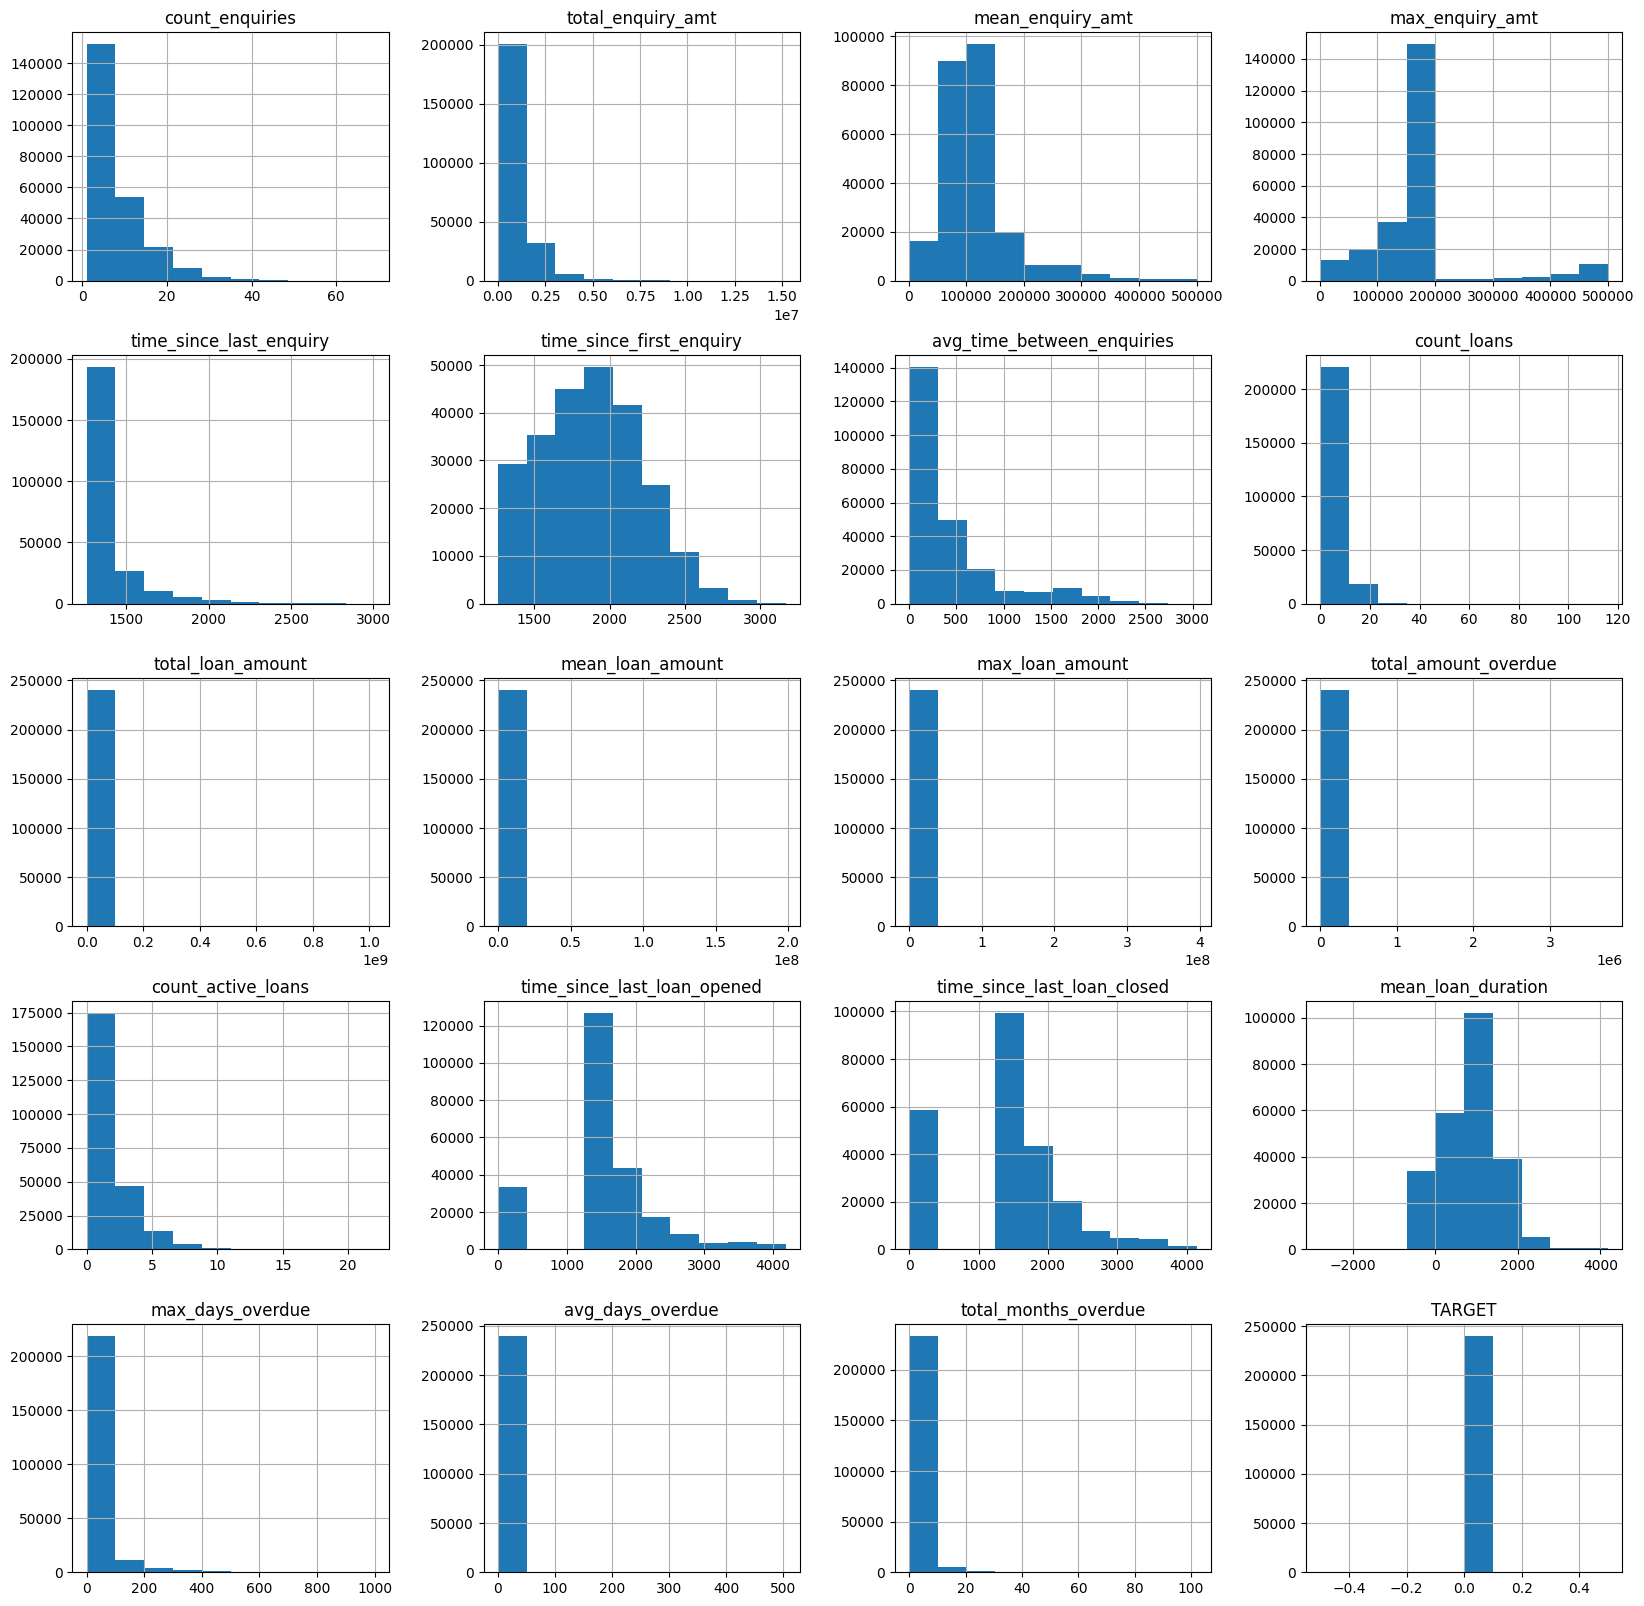

In [139]:
data_0 = final_train[final_train['TARGET'] == 0]

data_0.hist(figsize=(20, 20))
plt.show()

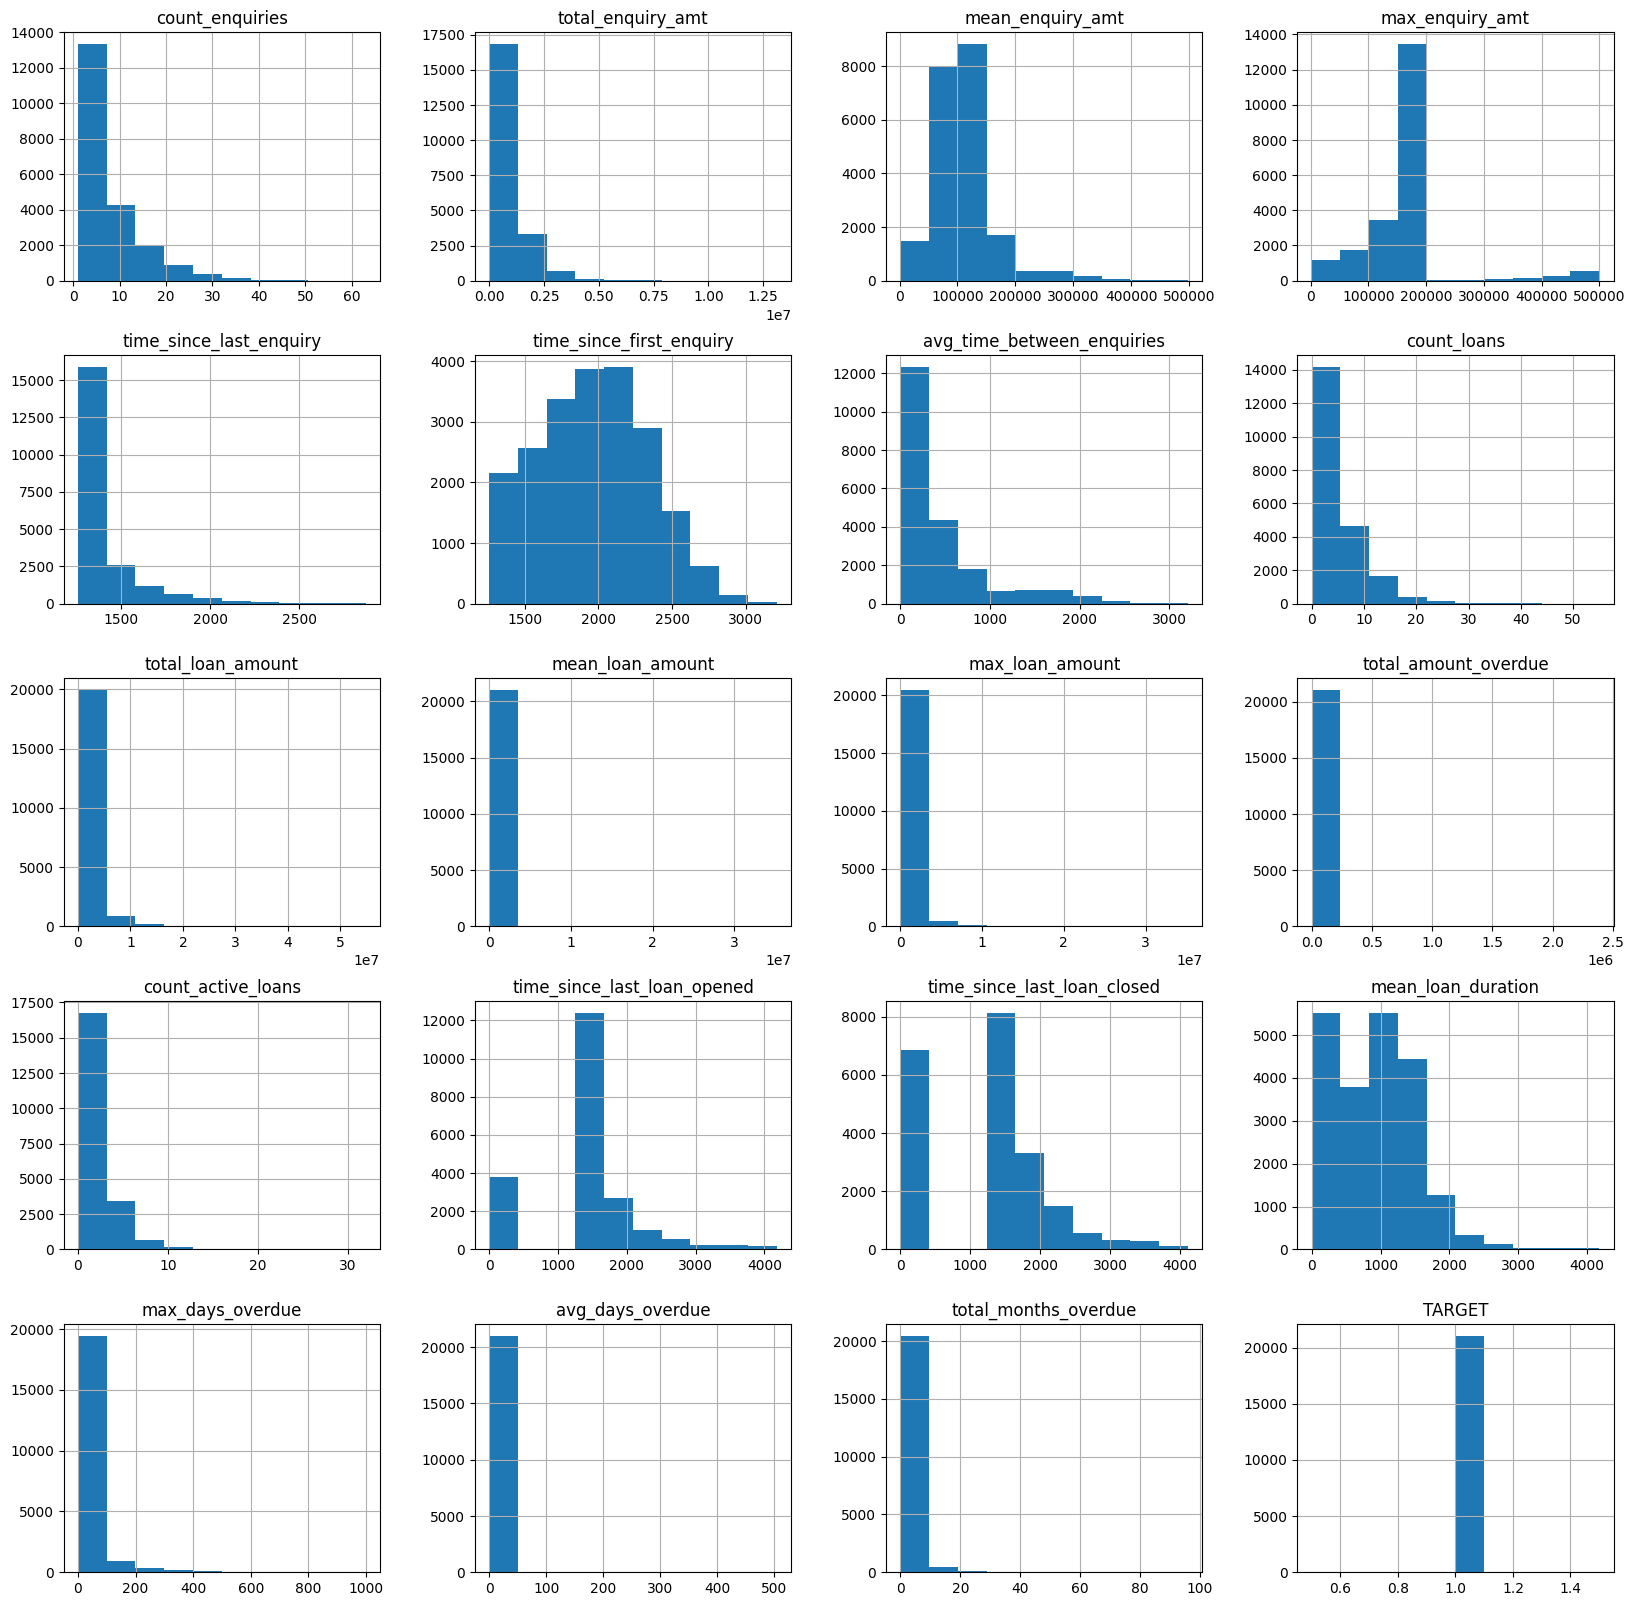

In [140]:
data_1 = final_train[final_train['TARGET'] == 1]

data_1.hist(figsize=(20, 20))
plt.show()

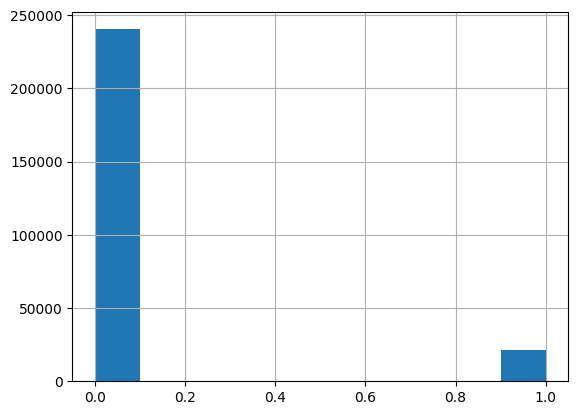

In [141]:
final_train['TARGET'].hist()
plt.show()

### FEATURE SELECTION

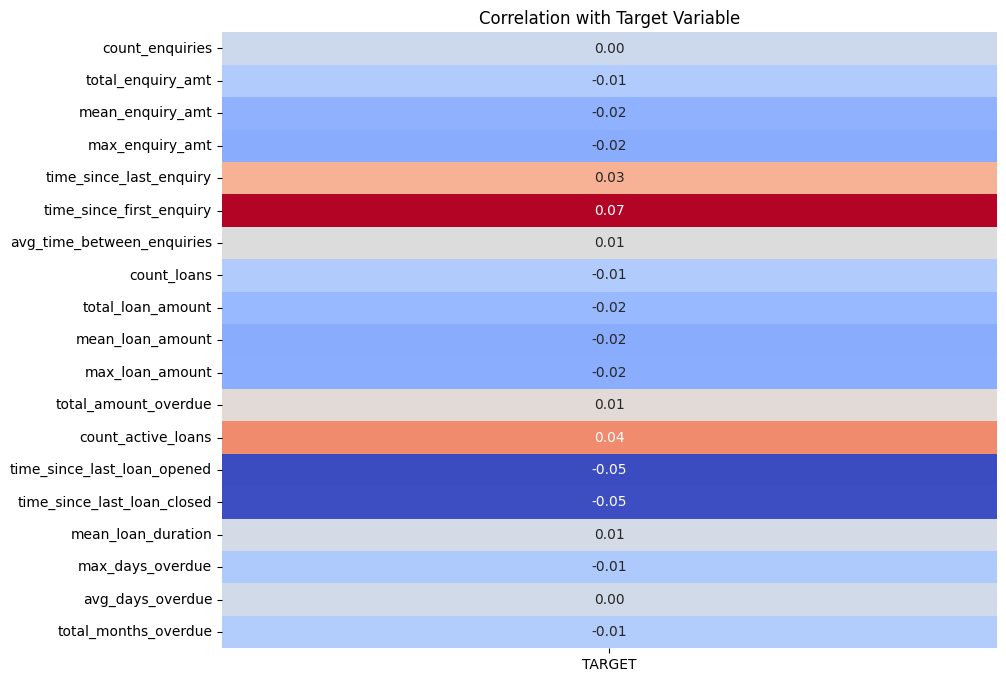

In [142]:
df = final_train.drop('uid', axis=1)
corr = df.corr()

target_corr = corr['TARGET'].drop('TARGET')

plt.figure(figsize=(10, 8))
sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title('Correlation with Target Variable')
plt.show()

In [143]:
positive_corr_columns = target_corr[target_corr > 0].index.tolist()

positive_corr_columns.append('uid')
df_positive_corr_test = final_test[positive_corr_columns]
positive_corr_columns.append('TARGET')
df_positive_corr_train = final_train[positive_corr_columns]

In [144]:
df_positive_corr_train.head()

,count_enquiries,time_since_last_enquiry,time_since_first_enquiry,avg_time_between_enquiries,total_amount_overdue,count_active_loans,mean_loan_duration,avg_days_overdue,uid,TARGET
0,11,1261,1931,193.100000,0.0,0.0,0.000,0.000000,AAA08065248,0
1,26,1262,2431,97.240000,0.0,0.0,511.000,2.106618,AAA09044550,0
2,14,1323,2169,166.846154,0.0,1.0,1445.000,0.000000,AAA10545297,0
3,15,1439,2618,187.000000,0.0,0.0,92.000,0.000000,AAA14112888,0
4,1,1399,1399,0.000000,0.0,3.0,1049.875,23.810855,AAA20326915,0


In [145]:
df_positive_corr_test.head()

,count_enquiries,time_since_last_enquiry,time_since_first_enquiry,avg_time_between_enquiries,total_amount_overdue,count_active_loans,mean_loan_duration,avg_days_overdue,uid
0,1,1278,1278,0.000000,0.0,0.0,0.000000,0.000000,AAA02107680
1,4,1290,1809,603.000000,0.0,2.0,818.833333,4.464286,AAA14437029
2,1,1676,1676,0.000000,0.0,2.0,1557.000000,2.333333,AAB12915377
3,14,1262,2024,155.692308,0.0,2.0,777.166667,0.000000,AAB55088883
4,17,1259,2232,139.500000,0.0,2.0,960.428571,6.693878,AAB68152393


In [146]:
df_positive_corr_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261383 entries, 0 to 261382
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   count_enquiries             261383 non-null  int64  
 1   time_since_last_enquiry     261383 non-null  int64  
 2   time_since_first_enquiry    261383 non-null  int64  
 3   avg_time_between_enquiries  261383 non-null  float64
 4   total_amount_overdue        261383 non-null  float64
 5   count_active_loans          261383 non-null  float64
 6   mean_loan_duration          261383 non-null  float64
 7   avg_days_overdue            261383 non-null  float64
 8   uid                         261383 non-null  object 
 9   TARGET                      261383 non-null  int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 19.9+ MB


## MODEL

In [147]:
X = df_positive_corr_train.drop(columns=["TARGET", "uid"])
y = df_positive_corr_train["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "XGBoost": XGBClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = roc_auc

for name, roc_auc in results.items():
    print(f"{name}: ROC_AUC = {roc_auc:.4f}")

Random Forest: ROC_AUC = 0.5618
Logistic Regression: ROC_AUC = 0.6026
XGBoost: ROC_AUC = 0.6160


In [148]:
xgb = XGBClassifier()

param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.3],
    "n_estimators": [100, 300, 500],
    "gamma": [0, 0.1, 0.3]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best ROC_AUC Score:", best_score)

best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Test ROC_AUC Score:", roc_auc)

Best Parameters: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best ROC_AUC Score: 0.6262756360146585
Test ROC_AUC Score: 0.6338241381379837


In [149]:
df_positive_corr_train.head()

,count_enquiries,time_since_last_enquiry,time_since_first_enquiry,avg_time_between_enquiries,total_amount_overdue,count_active_loans,mean_loan_duration,avg_days_overdue,uid,TARGET
0,11,1261,1931,193.100000,0.0,0.0,0.000,0.000000,AAA08065248,0
1,26,1262,2431,97.240000,0.0,0.0,511.000,2.106618,AAA09044550,0
2,14,1323,2169,166.846154,0.0,1.0,1445.000,0.000000,AAA10545297,0
3,15,1439,2618,187.000000,0.0,0.0,92.000,0.000000,AAA14112888,0
4,1,1399,1399,0.000000,0.0,3.0,1049.875,23.810855,AAA20326915,0


In [150]:
df_positive_corr_test.head()

,count_enquiries,time_since_last_enquiry,time_since_first_enquiry,avg_time_between_enquiries,total_amount_overdue,count_active_loans,mean_loan_duration,avg_days_overdue,uid
0,1,1278,1278,0.000000,0.0,0.0,0.000000,0.000000,AAA02107680
1,4,1290,1809,603.000000,0.0,2.0,818.833333,4.464286,AAA14437029
2,1,1676,1676,0.000000,0.0,2.0,1557.000000,2.333333,AAB12915377
3,14,1262,2024,155.692308,0.0,2.0,777.166667,0.000000,AAB55088883
4,17,1259,2232,139.500000,0.0,2.0,960.428571,6.693878,AAB68152393


In [151]:
df_positive_corr_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261383 entries, 0 to 261382
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   count_enquiries             261383 non-null  int64  
 1   time_since_last_enquiry     261383 non-null  int64  
 2   time_since_first_enquiry    261383 non-null  int64  
 3   avg_time_between_enquiries  261383 non-null  float64
 4   total_amount_overdue        261383 non-null  float64
 5   count_active_loans          261383 non-null  float64
 6   mean_loan_duration          261383 non-null  float64
 7   avg_days_overdue            261383 non-null  float64
 8   uid                         261383 non-null  object 
 9   TARGET                      261383 non-null  int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 19.9+ MB


In [152]:
df_positive_corr_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46127 entries, 0 to 46126
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   count_enquiries             46127 non-null  int64  
 1   time_since_last_enquiry     46127 non-null  int64  
 2   time_since_first_enquiry    46127 non-null  int64  
 3   avg_time_between_enquiries  46127 non-null  float64
 4   total_amount_overdue        46127 non-null  float64
 5   count_active_loans          46127 non-null  float64
 6   mean_loan_duration          46127 non-null  float64
 7   avg_days_overdue            46127 non-null  float64
 8   uid                         46127 non-null  object 
dtypes: float64(5), int64(3), object(1)
memory usage: 3.2+ MB


In [153]:
X = df_positive_corr_train.drop(['TARGET', 'uid'], axis=1)
y = df_positive_corr_train['TARGET']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

best_params = {
    'n_estimators': 100,
    'max_depth': 3,
    'learning_rate': 0.1,
    'gamma': 0.1,
    'scale_pos_weight': np.sum(y == 0) / np.sum(y == 1)
}

model = XGBClassifier(**best_params)

X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_valid)[:, 1]

auc_roc_score = roc_auc_score(y_valid, y_pred_prob)

print(f"AUC ROC Score: {auc_roc_score}")

AUC ROC Score: 0.8620764929546608


In [154]:
X_test = df_positive_corr_test.drop(['uid'], axis=1)
uids = df_positive_corr_test['uid']


y_test_pred_prob = model.predict_proba(X_test)[:, 1]

y_test_pred = (y_test_pred_prob <= 0.5).astype(int)

results = pd.DataFrame({
    'uid': uids,
    'prediction': y_test_pred
})

results.to_csv(r'C:\Users\ankur\Desktop\senior_ds_test\senior_ds_test\data\final_submission\final_submission_Ankur_Kumar.csv', index=False)

## OUTPUT SAVED